**Page 75-76 Exercises 6-1**:
The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is. The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded hinc06.xls, which is an Excel spreadsheet with information about household income, and converted it to hinc06.csv, a CSV file you will find in the repository for this book. You will also find hinc2.py, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under 5000.” 𝑇ℎ𝑒 ℎ𝑖𝑔ℎ𝑒𝑠 𝑡𝑟𝑎𝑛𝑔𝑒 𝑖𝑛𝑐𝑙𝑢𝑑𝑒𝑠 𝑟𝑒𝑠𝑝𝑜𝑛𝑑𝑒𝑛𝑡𝑠 𝑤ℎ𝑜 𝑚𝑎𝑑𝑒 “250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. hinc2.py provides InterpolateSample, which shows one way to model this data. It takes a DataFrame with a column, income, that contains the upper bound of each range, and freq, which contains the number of respondents in each frame.

It also takes log_upper, which is an assumed upper bound on the highest range, expressed in log10 dollars. The default value, log_upper=6.0 represents the assumption that the largest income among the respondents is 10^6, or one million dollars.

InterpolateSample generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a log10 scale.

In [41]:
#importing the necessairy packages 

import numpy as np
import hinc
import thinkplot
import thinkstats2

In [2]:
#loading data
df = hinc.ReadData()
df.head()

,income,freq,cumsum,ps
0,4999.0,4204,4204,0.034330
1,9999.0,4729,8933,0.072947
2,14999.0,6982,15915,0.129963
3,19999.0,7157,23072,0.188407
4,24999.0,7131,30203,0.246640


Makes a sample of log10 household income.  
Assumes that log10 income is uniform in each range.  
df: DataFrame with columns income and freq  
log_upper: log10 of the assumed upper bound for the highest range  
log_sample = NumPy array of log10 household income

In [4]:
# compute the log10 of the upper bound for each range
df['log_upper'] = np.log10(df.income)

In [5]:
# get the lower bounds by shifting the upper bound and filling in
# the first element
df['log_lower'] = df.log_upper.shift(1)
df.loc[0, 'log_lower'] = 3.0

In [6]:
# plug in a value for the unknown upper bound of the highest range
log_upper = 6.0
df.loc[41, 'log_upper'] = log_upper

In [7]:
# use the freq column to generate the right number of values in each range
##### changed  df.iterrows() because was throwing ypeError: 'numpy.float64' object cannot be interpreted
arrays = []
for row in  df.itertuples():  
    vals = np.linspace(row.log_lower, row.log_upper, row.freq)
    arrays.append(vals)

In [8]:
# collect the arrays into a single sample
log_sample = np.concatenate(arrays)
log_sample

array([3.        , 3.00016628, 3.00033256, ..., 5.99958621, 5.99979311,
       6.        ])

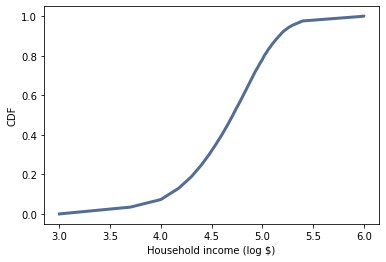

In [9]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [10]:
sample = np.power(10, log_sample)

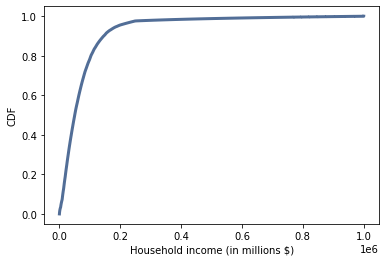

In [12]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income (in millions $)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [45]:
#Compute the median
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

Median(sample)

51226.45447894046

In [44]:
#Compute the mean.

def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

def Mean(xs):
    return RawMoment(xs, 1)


Mean(sample)

74278.70753118733

we can see that the Mean is greater than the median which means that to the distribution is skewed to the left

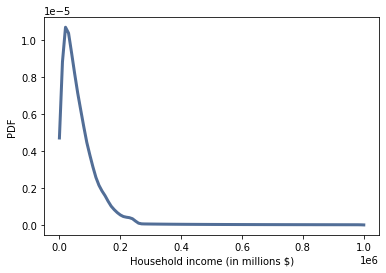

In [49]:
pdf = thinkstats2.EstimatedPdf(sample)
thinkplot.Pdf(pdf)
thinkplot.Config(xlabel='Household income (in millions $)', ylabel='PDF')

graph also confirm the findings. 

In [37]:
#####skewness and Pearson’s skewness of the resulting sample

def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)


def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

def Skewness(xs):
    return StandardizedMoment(xs, 3)

def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [46]:
Skewness(sample), PearsonMedianSkewness(sample)


(4.949920244429583, 0.7361258019141782)

And both ways of computing skewness are positive. which confirm skewness to the right

What fraction of households report a taxable income below the mean? 

In [63]:
mean = Mean(sample)

In [69]:
print('fraction of households report a taxable income below the mean is', round(cdf.Prob(mean)*100,2),'%')

fraction of households report a taxable income below the mean is 66.0 %


How do the results depend on the assumed upper bound?

the result we have so far is based on the assumption that the upper limit is $1million..

trying with upper band is 10 millions


In [70]:
def InterpolateSample(df, log_upper=10.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for row in  df.itertuples():  
        vals = np.linspace(row.log_lower, row.log_upper, row.freq)
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [84]:
import numpy as np

#loading data
df = hinc.ReadData()

log_sample10 = InterpolateSample(df, log_upper=7.0)

In [85]:
sample = np.power(10, log_sample10)

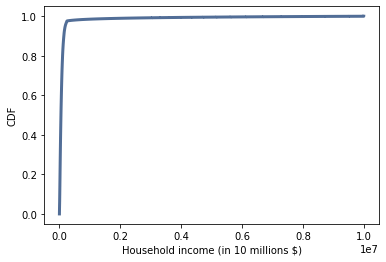

In [88]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income (in 10 millions $)',
               ylabel='CDF')

In [87]:
print( 'median:', Median(sample), ' mean: ', Mean(sample))
print('Skewness: ', Skewness(sample), 'PearsonMedianSkewness: ', PearsonMedianSkewness(sample))

median: 51226.45447894046  mean:  124267.39722164685
Skewness:  11.603690267537793 PearsonMedianSkewness:  0.39156450927742087


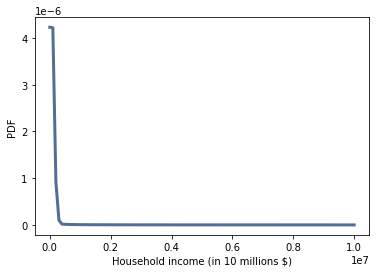

In [89]:
pdf = thinkstats2.EstimatedPdf(sample)
thinkplot.Pdf(pdf)
thinkplot.Config(xlabel='Household income (in 10 millions $)', ylabel='PDF')

based on the assumption that the largest income among the respondents is 10^7, or one 10 million dollars., and from the calculation the data seems to be positively skewed.

but Without better information about the top of this distribution, we can't say much about the skewness of the distribution
